In [1]:
import numpy as np 
import pandas as pd 
import sklearn
# библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# библиотеки для создания и обучения модели
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

# Импортируем библиотеки, необходимые для преобразования признаков
import category_encoders as ce
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from geopy.geocoders import Nominatim
from geopy.distance import geodesic
import geopy

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


/opt/conda/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


Представьте, что вы работаете дата-сайентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов обнаружения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель ведёт себя нечестно, и его стоит проверить.

In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [4]:
# Подгрузим наши данные из соревнования

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

# 1. Знакомство с данными

+ hotel_address — адрес отеля;
+ review_date — дата, когда рецензент разместил соответствующий отзыв;
+ average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
+ hotel_name — название отеля;
+ reviewer_nationality — страна рецензента;
+ negative_review — отрицательный отзыв, который рецензент дал отелю;
+ review_total_negative_word_counts — общее количество слов в отрицательном отзыв;
+ positive_review — положительный отзыв, который рецензент дал отелю;
+ review_total_positive_word_counts — общее количество слов в положительном отзыве.
+ reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;
+ total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;
+ total_number_of_reviews — общее количество действительных отзывов об отеле;
+ tags — теги, которые рецензент дал отелю;
+ days_since_review — количество дней между датой проверки и датой очистки;
+ additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
+ lat — географическая широта отеля;
+ lng — географическая долгота отеля.


In [5]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [7]:
data.describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lat,lng,sample,reviewer_score
count,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,512470.000000,512470.000000,515738.000000,515738.000000
mean,498.081836,8.397487,18.539450,2743.743944,17.776458,7.166001,49.442439,2.823803,0.749999,6.297672
std,500.538467,0.548048,29.690831,2317.464868,21.804185,11.040228,3.466325,4.579425,0.433014,3.902295
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.000000,41.328376,-0.369758,0.000000,0.000000
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.000000,48.214662,-0.143372,0.250000,0.625000
50%,341.000000,8.400000,9.000000,2134.000000,11.000000,3.000000,51.499981,0.010607,1.000000,7.900000
75%,660.000000,8.800000,23.000000,3613.000000,22.000000,8.000000,51.516288,4.834443,1.000000,9.600000
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.000000,52.400181,16.429233,1.000000,10.000000


In [8]:
data.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0
3,Piazza Della Repubblica 17 Central Station 201...,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,45.479888,9.196298,0,0.0
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,5/16/2016,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Class...",444 day,52.370545,4.888644,0,0.0


In [9]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


# 2. Очистка данных.

При знакомстве с данными мы обнаружили два признака с отсутствующими данными.
Это 'lat' и 'lng'

In [10]:
data.isnull().sum()

hotel_address                                    0
additional_number_of_scoring                     0
review_date                                      0
average_score                                    0
hotel_name                                       0
reviewer_nationality                             0
negative_review                                  0
review_total_negative_word_counts                0
total_number_of_reviews                          0
positive_review                                  0
review_total_positive_word_counts                0
total_number_of_reviews_reviewer_has_given       0
tags                                             0
days_since_review                                0
lat                                           3268
lng                                           3268
sample                                           0
reviewer_score                                   0
dtype: int64

Решим вопрос с отсутствующими данными в признаках 'lat', 'lng'.


In [11]:
# создаем датафрейм с алресами где нет координат.
df_coord = data[data['lat'].isnull()].groupby('hotel_address').count()[['lat','lng']]
df_coord

,lat,lng
hotel_address,,
20 Rue De La Ga t 14th arr 75014 Paris France,0,0
23 Rue Damr mont 18th arr 75018 Paris France,0,0
4 rue de la P pini re 8th arr 75008 Paris France,0,0
Bail n 4 6 Eixample 08010 Barcelona Spain,0,0
Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria,0,0
Hasenauerstra e 12 19 D bling 1190 Vienna Austria,0,0
Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria,0,0
Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria,0,0
Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria,0,0


При помощи библиотеки geopy находим отсутствующие координаты.

from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent = "zhyravkovv@mail.ru")
location = geolocator.geocode("Wahringer Strasse 12 09 Alsergrund 1090 Vienna Austria")
print(location.address)

In [12]:
coordinate = [[48.8399957, 2.3070823], 
           [48.8889127, 2.3309643], 
           [48.8753208, 2.3212033], 
           [41.391552, 2.1757053],
           [48.2208555, 16.3644228],
           [48.233592, 16.3434781],
           [48.2094054, 16.3512565],
           [48.2095525, 16.3492746],
           [48.1888183, 16.381591],
           [48.1868142, 16.418528],
           [41.3749946, 2.1102353],
           [48.219573, 16.2834034],
           [41.3832425, 2.1607609],
           [48.2458909, 16.3397395],
           [48.2135906, 16.3777195],
           [48.2168032, 16.357717],
           [48.220414, 16.3536299]]

In [13]:
# Заносим данные в созданный датафрейм.
for i in range(len(df_coord)):
    df_coord.iloc[i] = coordinate[i]
df_coord

,lat,lng
hotel_address,,
20 Rue De La Ga t 14th arr 75014 Paris France,48.839996,2.307082
23 Rue Damr mont 18th arr 75018 Paris France,48.888913,2.330964
4 rue de la P pini re 8th arr 75008 Paris France,48.875321,2.321203
Bail n 4 6 Eixample 08010 Barcelona Spain,41.391552,2.175705
Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria,48.220855,16.364423
Hasenauerstra e 12 19 D bling 1190 Vienna Austria,48.233592,16.343478
Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria,48.209405,16.351257
Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria,48.209553,16.349275
Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria,48.188818,16.381591


In [14]:
# Переносим данные в наш основной датафрейм.
data = data.set_index('hotel_address')
data.update(df_coord)
data = data.reset_index()

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

Составим списки числовых и объектных признаков.

In [16]:
numeric_columns = [s for s in data.columns if data[s].dtypes == 'int64'
                   or data[s].dtypes == 'float64']

In [17]:
numeric_columns

['additional_number_of_scoring',
 'average_score',
 'review_total_negative_word_counts',
 'total_number_of_reviews',
 'review_total_positive_word_counts',
 'total_number_of_reviews_reviewer_has_given',
 'lat',
 'lng',
 'sample',
 'reviewer_score']

In [18]:
object_columns = [s for s in data.columns if data[s].dtypes == 'object']

In [19]:
object_columns

['hotel_address',
 'review_date',
 'hotel_name',
 'reviewer_nationality',
 'negative_review',
 'positive_review',
 'tags',
 'days_since_review']

In [20]:
data.nunique(dropna=False)

hotel_address                                   1493
additional_number_of_scoring                     480
review_date                                      731
average_score                                     34
hotel_name                                      1492
reviewer_nationality                             227
negative_review                               330011
review_total_negative_word_counts                402
total_number_of_reviews                         1142
positive_review                               412601
review_total_positive_word_counts                365
total_number_of_reviews_reviewer_has_given       198
tags                                           55242
days_since_review                                731
lat                                             1489
lng                                             1489
sample                                             2
reviewer_score                                    38
dtype: int64

# 3.Проектирование признаков.

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [22]:
data.describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lat,lng,sample,reviewer_score
count,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000
mean,498.081836,8.397487,18.539450,2743.743944,17.776458,7.166001,49.432403,2.893461,0.749999,6.297672
std,500.538467,0.548048,29.690831,2317.464868,21.804185,11.040228,3.460245,4.667445,0.433014,3.902295
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.000000,41.328376,-0.369758,0.000000,0.000000
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.000000,48.214066,-0.143372,0.250000,0.625000
50%,341.000000,8.400000,9.000000,2134.000000,11.000000,3.000000,51.499981,0.019886,1.000000,7.900000
75%,660.000000,8.800000,23.000000,3613.000000,22.000000,8.000000,51.516288,4.841163,1.000000,9.600000
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.000000,52.400181,16.429233,1.000000,10.000000


## Рассмотрим признак 'hotel_address'

Из этого признака мы можем взять информацию о городе, стране и почтовом индексе где расположен отель. 

In [23]:
def get_city(arg):
    if arg.split()[-2] == 'United':
        return arg.split()[-5]
    else:
        return arg.split()[-2]

In [24]:
data['city'] = data['hotel_address'].apply(get_city)

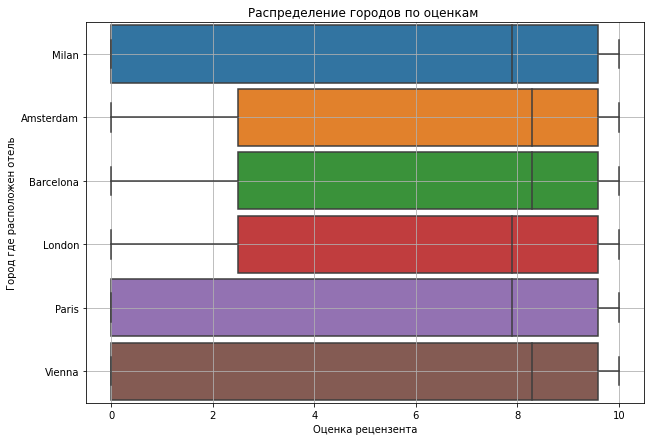

In [25]:
fig = plt.figure(figsize=(10, 7))
boxplot = sns.boxplot(
    data= data,
    y='city',
    x='reviewer_score',
    orient='h',
    width=0.9
)
boxplot.set_title('Распределение городов по оценкам ');
boxplot.set_xlabel('Оценка рецензента');
boxplot.set_ylabel('Город где расположен отель');
boxplot.grid()

<AxesSubplot:xlabel='reviewer_score', ylabel='city'>

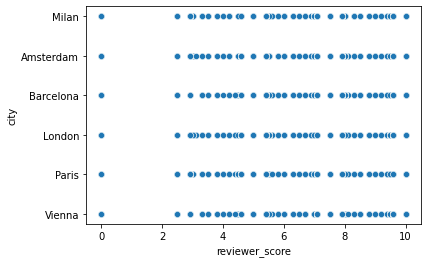

In [26]:
sns.scatterplot(data=data, x="reviewer_score", y="city")

In [27]:
def get_country(arg):
    if arg.split()[-1] == 'Kingdom':
        return arg.split()[-2] + ' ' + arg.split()[-1]
    else:
        return arg.split()[-1]

In [28]:
data['country'] = data['hotel_address'].apply(get_country)

In [29]:
def get_mail_index(arg):
    if arg.split()[-1] == 'Kingdom':
        return arg.split()[-4] + ' ' + arg.split()[-3]
    else:
        return arg.split()[-3]

In [30]:
data['mail_index'] = data['hotel_address'].apply(get_mail_index)

### Создадим признаки населения и площади страны в которой расположен отель.

In [31]:
countries_df = pd.DataFrame({
'country': ['United Kingdom', 'Netherlands', 'Italy', 'Austria',
'Spain', 'France'],
'population': [65341183, 16979120 , 60665551, 8741753, 46438422, 64513242],
'square': [244820, 41526, 301340, 83858, 497304, 547030]
})

In [32]:
data = data.merge( countries_df, on='country', how='left' )

## Преобразуем признак 'review_date' и 'days_since_review'.

In [33]:
data['review_date'] = pd.to_datetime(data['review_date'])

In [34]:
data['review_month'] = data['review_date'].dt.month
data['review_day_of_week'] = data['review_date'].dt.dayofweek

## Создаем признак разница между датой составления отзыва и датой первого отзыва.

In [35]:
data['review_duration'] = abs(data['review_date'].min() - data['review_date'])

In [36]:
def get_day(arg):
    return (str(arg)).split()[0]
data['days_since_review'] = data['days_since_review'].apply(get_day)
data['review_duration'] = data['review_duration'].apply(get_day)

## Создадим признак 'distance' расстояние от отедя до центра города.

In [37]:
data['coord'] = list(zip(data['lat'],data['lng']))

In [38]:
df_center = pd.DataFrame({'city':['London',
                                  'Amsterdam',
                                  'Barcelona',
                                  'Milan',
                                  'Vienna',
                                  'Paris'],
                  'coord_center':[(51.5085, -0.12574),
                                   (52.374, 4.88969),
                                   (41.3888, 2.15899),
                                   (45.4643, 9.18951),
                                   (48.2085, 16.3721),
                                   (48.8534, 2.3488)]})

In [39]:
data = data.merge(df_center, on = 'city', how = 'left')

In [40]:
 from geopy.distance import geodesic as GD 

In [41]:
def get_distance(arg):
    arg1 = arg['coord']
    arg2 = arg['coord_center']
    return round(GD(arg1, arg2).km, 1) 


In [42]:
data['distance'] = data.apply(lambda arg: get_distance (arg), axis = 1)

In [43]:
data['distance']

0         7.8
1         4.0
2         0.5
3         1.8
4         0.4
         ... 
515733    4.8
515734    2.7
515735    1.4
515736    2.5
515737    4.8
Name: distance, Length: 515738, dtype: float64

In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 515737
Data columns (total 29 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515738 non-null  object        
 1   additional_number_of_scoring                515738 non-null  int64         
 2   review_date                                 515738 non-null  datetime64[ns]
 3   average_score                               515738 non-null  float64       
 4   hotel_name                                  515738 non-null  object        
 5   reviewer_nationality                        515738 non-null  object        
 6   negative_review                             515738 non-null  object        
 7   review_total_negative_word_counts           515738 non-null  int64         
 8   total_number_of_reviews                     515738 non-null  int64        

## Признак процент настоящих отзывов от общего числа отзывов.

In [45]:
data['percent_real_review'] = round(data['additional_number_of_scoring'] / data['total_number_of_reviews'] * 100,2)

In [46]:
data['percent_real_review']

0          5.42
1         12.20
2         13.11
3         15.62
4         17.79
          ...  
515733    17.34
515734     8.44
515735    16.61
515736    23.29
515737    18.36
Name: percent_real_review, Length: 515738, dtype: float64

## Признак национальность гостя. 

In [47]:
data['reviewer_nationality']

0                    United Kingdom 
1                           Belgium 
2                            Sweden 
3          United States of America 
4                    United Kingdom 
                     ...            
515733                       France 
515734                       Turkey 
515735                  Netherlands 
515736         United Arab Emirates 
515737                    Australia 
Name: reviewer_nationality, Length: 515738, dtype: object

In [48]:
popular_nationality = data['reviewer_nationality'].value_counts().nlargest(55).index

In [49]:
popular_nationality

Index([' United Kingdom ', ' United States of America ', ' Australia ',
       ' Ireland ', ' United Arab Emirates ', ' Saudi Arabia ',
       ' Netherlands ', ' Switzerland ', ' Germany ', ' Canada ', ' France ',
       ' Israel ', ' Italy ', ' Belgium ', ' Turkey ', ' Kuwait ', ' Spain ',
       ' Romania ', ' Russia ', ' South Africa ', ' India ', ' Greece ',
       ' China ', ' Sweden ', ' New Zealand ', ' Singapore ', ' Hong Kong ',
       ' Poland ', ' Qatar ', ' Austria ', ' Egypt ', ' Norway ',
       ' Czech Republic ', ' Lebanon ', ' Hungary ', ' Malaysia ',
       ' Thailand ', ' Brazil ', ' Portugal ', ' Finland ', ' Denmark ',
       ' Malta ', ' Bahrain ', ' Indonesia ', ' Cyprus ', ' Luxembourg ',
       ' Croatia ', ' Oman ', ' Bulgaria ', ' Japan ', ' Serbia ', ' Ukraine ',
       ' Iran ', ' South Korea ', ' Philippines '],
      dtype='object')

In [50]:
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x if x in popular_nationality else 'other')
data['reviewer_nationality'].value_counts()

 United Kingdom               245246
 United States of America      35437
 Australia                     21686
other                          20791
 Ireland                       14827
 United Arab Emirates          10235
 Saudi Arabia                   8951
 Netherlands                    8772
 Switzerland                    8678
 Germany                        7941
 Canada                         7894
 France                         7296
 Israel                         6610
 Italy                          6114
 Belgium                        6031
 Turkey                         5444
 Kuwait                         4920
 Spain                          4737
 Romania                        4552
 Russia                         3900
 South Africa                   3821
 India                          3437
 Greece                         3406
 China                          3400
 Sweden                         3368
 New Zealand                    3237
 Singapore                      3091
 

In [51]:
import category_encoders as ce

In [52]:
data.columns

Index(['hotel_address', 'additional_number_of_scoring', 'review_date',
       'average_score', 'hotel_name', 'reviewer_nationality',
       'negative_review', 'review_total_negative_word_counts',
       'total_number_of_reviews', 'positive_review',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'tags',
       'days_since_review', 'lat', 'lng', 'sample', 'reviewer_score', 'city',
       'country', 'mail_index', 'population', 'square', 'review_month',
       'review_day_of_week', 'review_duration', 'coord', 'coord_center',
       'distance', 'percent_real_review'],
      dtype='object')

In [53]:
data = pd.get_dummies(data, columns=['city', 'country'])

In [54]:
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality']) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(data['reviewer_nationality'])
data = pd.concat([data, type_bin], axis=1)

## Преобразование признаков 'positive_review' и 'negative_review'

In [55]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

[nltk_data] Error loading vader_lexicon: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


In [56]:
data['scores_negative'] = data['negative_review'].apply(lambda negative_review: sid.polarity_scores(negative_review))
data['scores_positive'] = data['positive_review'].apply(lambda positive_review: sid.polarity_scores(positive_review))

In [57]:
data['scores_negative']

0         {'neg': 0.129, 'neu': 0.747, 'pos': 0.125, 'co...
1         {'neg': 0.216, 'neu': 0.784, 'pos': 0.0, 'comp...
2         {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
3         {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound...
4         {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound...
                                ...                        
515733    {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound...
515734    {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound...
515735    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
515736    {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound...
515737    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
Name: scores_negative, Length: 515738, dtype: object

In [58]:
data['negative_neg'] = data['scores_negative'].apply(lambda arg: list((arg).values())[0])
data['negative_neu'] = data['scores_negative'].apply(lambda arg: list((arg).values())[1])
data['negative_pos'] = data['scores_negative'].apply(lambda arg: list((arg).values())[2])
data['negative_compound'] = data['scores_negative'].apply(lambda arg: list((arg).values())[-1])

In [59]:
data['positive_neg'] = data['scores_positive'].apply(lambda arg: list((arg).values())[0])
data['positive_neu'] = data['scores_positive'].apply(lambda arg: list((arg).values())[1])
data['positive_pos'] = data['scores_positive'].apply(lambda arg: list((arg).values())[2])
data['positive_compound'] = data['scores_positive'].apply(lambda arg: list((arg).values())[-1])

## Признак 'tags'

In [60]:
def get_tags(arg): # Функция для очистки строки от лишних символов.
    tags = []
    for tag in list(arg[2:-2].strip().split(' \', \' ')):
        tag = tag.replace(' ', '_')
        tags.append(tag)
    return tags
data.tags = data.tags.apply(get_tags)

In [61]:
def get_pet(arg):
    if arg[0] == 'With_a_pet':
        return 1
    else:
        return 0
data['with_a_pet'] = data['tags'].apply(get_pet)

In [62]:
data['with_a_pet'].value_counts()

0    514333
1      1405
Name: with_a_pet, dtype: int64

In [63]:
def get_trip(arg):
    if arg[0] == 'Leisure_trip' or arg[0] == 'Business_trip':
        return 1
    else:
        return 0
data['type_trip'] = data['tags'].apply(get_trip)
        

In [64]:
data['type_trip'].value_counts()

1    499420
0     16318
Name: type_trip, dtype: int64

In [65]:
def get_submitted(arg):
    if arg[-1] == 'Submitted_from_a_mobile_device':
        return 1
    else:
        return 0
data['submitted'] = data['tags'].apply(get_submitted)

In [66]:
data['submitted'].value_counts()

1    307640
0    208098
Name: submitted, dtype: int64

In [67]:
type_guests = ['Solo_traveler', 'Couple', 'Group', 'Family_with_young_children', 'Family_with_older_children', 'Travelers_with_friends']

In [68]:
def get_guest(arg):
    for i in arg:
        if i in type_guests:
            return i
data['type_guests'] = data['tags'].apply(get_guest)

In [69]:
data['type_guests'].value_counts()

Couple                        252294
Solo_traveler                 108545
Group                          65392
Family_with_young_children     61015
Family_with_older_children     26349
Travelers_with_friends          2143
Name: type_guests, dtype: int64

In [70]:
import re
def get_count_nights(arg):
    arg = str(arg)
    st = re.compile('Stayed\w+')
    res = str(st.findall(arg))[2:-2]
    return res
data['count_nights'] = data['tags'].apply(get_count_nights)

In [71]:
data['count_nights']

0         Stayed_2_nights
1          Stayed_1_night
2          Stayed_1_night
3          Stayed_1_night
4         Stayed_2_nights
               ...       
515733    Stayed_2_nights
515734    Stayed_4_nights
515735     Stayed_1_night
515736    Stayed_2_nights
515737    Stayed_4_nights
Name: count_nights, Length: 515738, dtype: object

In [72]:
data['diff_review_word_counts'] = data['review_total_positive_word_counts'] - data['review_total_negative_word_counts']

In [73]:
data['diff_review_word_counts']

0         10
1        -10
2          2
3         27
4          7
          ..
515733    10
515734    93
515735    -3
515736     6
515737     0
Name: diff_review_word_counts, Length: 515738, dtype: int64

## Создадим признак количество тегов 'count_tags'

In [74]:
def get_count_tags(arg):
    return round(len(arg)/6*100)
data['count_tags'] = data['tags'].apply(get_count_tags)

In [75]:
data['count_tags']

0         67
1         67
2         83
3         67
4         83
          ..
515733    83
515734    83
515735    67
515736    67
515737    67
Name: count_tags, Length: 515738, dtype: int64

# 4.Кодирование признаков

In [76]:
data = pd.get_dummies(data, columns=['type_guests'])

In [77]:
bin_encoder = ce.BinaryEncoder(cols=['count_nights']) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(data['count_nights'])
data = pd.concat([data, type_bin], axis=1)

In [78]:
#data['country'] = data['country'].astype('category').cat.codes#
#data['city'] = data['city'].astype('category').cat.codes
data['count_tags'] = data['count_tags'].astype('category').cat.codes
data['diff_review_word_counts'] = data['diff_review_word_counts'].astype('category').cat.codes
data['population'] = data['population'].astype('category').cat.codes
data['coord'] = data['coord'].astype('category').cat.codes
data['square'] = data['square'].astype('category').cat.codes
data['days_since_review'] = data['days_since_review'].astype('category').cat.codes
data['review_duration'] = data['review_duration'].astype('category').cat.codes
data['hotel_name'] = data['hotel_name'].astype('category').cat.codes
data['mail_index'] = data['mail_index'].astype('category').cat.codes
data['distance'] = data['distance'].astype('category').cat.codes
data['percent_real_review'] = data['percent_real_review'].astype('category').cat.codes
data['total_number_of_reviews_reviewer_has_given'] = data['total_number_of_reviews_reviewer_has_given'].astype('category').cat.codes

# 5.Отбор признаков

In [79]:
data = data.select_dtypes(exclude=['object'])

In [80]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 515737
Data columns (total 65 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   additional_number_of_scoring                515738 non-null  int64         
 1   review_date                                 515738 non-null  datetime64[ns]
 2   average_score                               515738 non-null  float64       
 3   hotel_name                                  515738 non-null  int16         
 4   review_total_negative_word_counts           515738 non-null  int64         
 5   total_number_of_reviews                     515738 non-null  int64         
 6   review_total_positive_word_counts           515738 non-null  int64         
 7   total_number_of_reviews_reviewer_has_given  515738 non-null  int16         
 8   days_since_review                           515738 non-null  int16        

<AxesSubplot:>

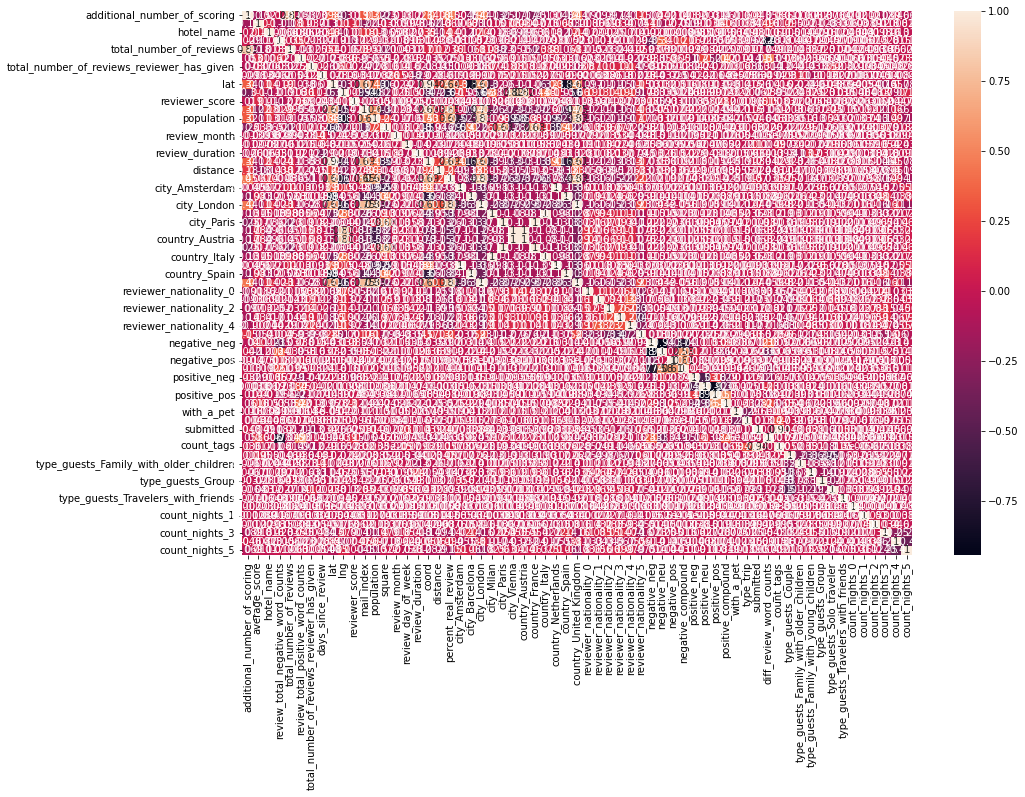

In [81]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

In [82]:
data.drop(['review_date'], axis = 1, inplace=True)

In [83]:
data.drop(['lat', 'lng'], axis=1, inplace=True)

In [84]:
data = data[['diff_review_word_counts',                  
'positive_compound',                            
'average_score',                               
'negative_compound',                            
'days_since_review',                            
'review_duration',                               
'review_total_negative_word_counts',             
'hotel_name',                                 
'percent_real_review',                         
'distance',                                     
'total_number_of_reviews_reviewer_has_given',    
'total_number_of_reviews',                       
'coord',                                         
'additional_number_of_scoring',                  
'mail_index',                                   
'negative_neu',                                  
'review_month',                                  
'review_total_positive_word_counts',             
'negative_neg',                                  
'review_day_of_week',                           
'positive_neu',                                  
'positive_pos',                                  
'negative_pos',                                  
'positive_neg',                                  
'reviewer_nationality_1',                        
'count_nights_5',                                
'reviewer_nationality_4',                        
'type_guests_Solo_traveler',                     
'count_nights_4',                                
'type_guests_Couple',                            
'count_tags',                                 
'reviewer_nationality_3',                      
'reviewer_nationality_2',                     
'reviewer_nationality_5',                       
'type_guests_Family_with_young_children',        
'count_nights_3',                               
'submitted',                                     
'type_guests_Group',                             
'square',                                        
'reviewer_nationality_0',
'sample',
'reviewer_score']]

In [85]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [86]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [87]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 41), (386803, 41), (386803, 40), (309442, 40), (77361, 40))

In [88]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [89]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [90]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.3s finished


In [91]:
def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.maximum(np.ones(len(y_true)), np.abs(y_true))))*100

print('MAPE:', MAPE(y_test, y_pred))

MAPE: 12.529194100712907


<AxesSubplot:>

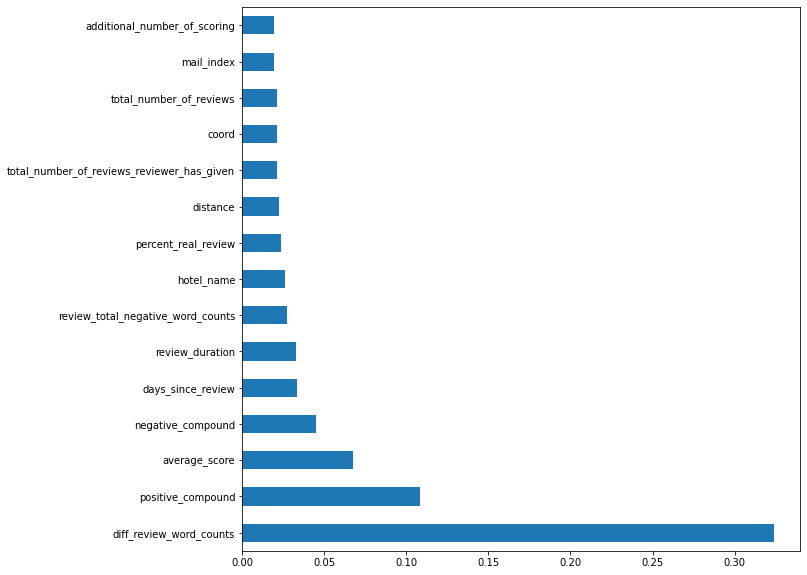

In [92]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [93]:
test_data.sample(10)

,diff_review_word_counts,positive_compound,average_score,negative_compound,days_since_review,review_duration,review_total_negative_word_counts,hotel_name,percent_real_review,distance,...,reviewer_nationality_3,reviewer_nationality_2,reviewer_nationality_5,type_guests_Family_with_young_children,count_nights_3,submitted,type_guests_Group,square,reviewer_nationality_0,reviewer_score
110038,378,-0.2960,8.6,0.5927,218,374,35,215,275,28,...,0,0,0,0,0,0,1,4,0,0.0
49120,400,0.8720,8.8,-0.7096,455,138,0,347,225,24,...,1,1,1,0,1,1,0,3,0,0.0
106298,405,0.8883,9.1,-0.7096,242,351,0,1489,728,34,...,1,0,0,0,0,0,0,2,0,0.0
89130,394,0.4927,9.1,0.4215,309,283,3,342,446,7,...,1,0,1,0,0,1,0,4,0,0.0
12836,431,0.8591,8.4,-0.7096,94,498,0,286,772,45,...,1,0,1,0,0,0,0,2,0,0.0
40082,398,0.3384,8.8,-0.6369,325,267,11,347,225,24,...,1,1,0,0,0,0,0,3,1,0.0
55873,361,0.0000,7.8,0.0717,626,645,39,1018,951,43,...,1,0,0,0,0,1,0,2,0,0.0
114552,378,0.0000,7.5,0.0000,292,300,18,516,837,33,...,1,0,1,1,1,1,0,2,0,0.0
98318,379,0.9835,9.1,-0.8579,143,450,54,1163,804,5,...,0,0,1,0,0,0,1,0,0,0.0
31039,387,0.3400,8.2,0.0000,499,93,6,1142,878,26,...,0,0,0,0,0,0,0,2,1,0.0


In [94]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [95]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [96]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.1s finished


In [97]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [98]:
list(sample_submission)

['reviewer_score', 'id']

In [99]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.529,488440
1,7.263,274649
2,8.397,374688
3,9.697,404352
4,9.551,451596
5,9.110,302161
6,7.523,317079
7,7.857,13963
8,8.304,159785
9,7.392,195089
